# Convolutional Neural Networks with PyTorch

Before, we were introduced to what neural networks were, and how we could create an MLP for classifying handwritten digits. However, we saw that we only got around 75% accuracy, which is not that great. In this notebook, we're going to learn about a new type of neural network which is the bedrock of modern computer vision: the convolutional neural network (CNN).

From the introduction of the research paper *[Deep Learning for Classical Japanese Literature](https://arxiv.org/pdf/1812.01718.pdf)* (2013):

> Recorded historical documents give us a peek into the past. We are able to glimpse the world before
our time; and see its culture, norms, and values to reflect on our own. Japan has very unique historical
pathway. Historically, Japan and its culture was relatively isolated from the West, until the Meiji
restoration in 1868 where Japanese leaders reformed its education system to modernize its culture.
This caused drastic changes in the Japanese language, writing and printing systems. Due to the
modernization of Japanese language in this era, cursive Kuzushiji (くずし字) script is no longer
taught in the official school curriculum. Even though Kuzushiji had been used for over 1000 years,
most Japanese natives today cannot read books written or published over 150 years ago.

![Kuzushiji](images/kuzushiji_art.jpg)

So now we can see that not only can we use machine learning to detect handwritten digits, we can actually apply our knowledge in deep learning to help preserve Japanese culture and historical artifacts! The fact that we can contribute towards actually solving real-world problems like preservation of culture and history is one of the most exciting aspects of machine learning and deep learning.

Let's go ahead and import our libraries, download the KMNIST (Kuzushiji-MNIST) datasets, and take a look at one of our example images.

In [ ]:
# Uncomment if in Google Colab
# !pip install -q gradio

In [23]:
# Import the necessary libraries.

import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

import skimage
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.datasets as datasets
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Download the dataset that we will use.

train_mnist = datasets.MNIST(
    root='dataset/',
    train=True,
    transform=Compose([RandomCrop(24), ToTensor()]),
    download=True)
test_mnist = datasets.MNIST(
    root='dataset/',
    train=False,
    transform=Compose([RandomCrop(24), ToTensor()]),
    download=True)

train_dataset = datasets.KMNIST(
    root='dataset/',
    train=True,
    transform=ToTensor(),
    download=True)
test_dataset = datasets.KMNIST(
    root='dataset/',
    train=False,
    transform=ToTensor(),
    download=True)

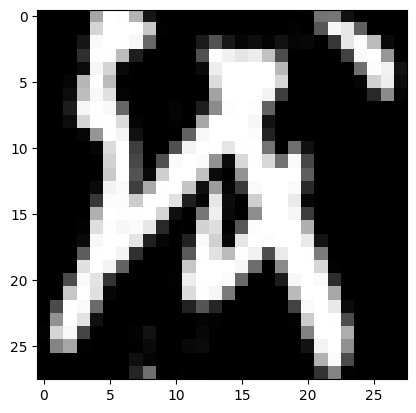

In [5]:
rand_int = np.random.choice(len(train_dataset))
plt.imshow(train_dataset[rand_int][0][0], cmap='Greys_r')

## Part 1: Features, Filters, and Kernels

Let's take this cameraman picture and step away from neural networks for a bit.

In [ ]:
cameraman = Image.fromarray(skimage.data.camera())
transform = Compose([
    ToTensor(),
    Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
])
cameraman = transform(cameraman)

plt.imshow(cameraman[0], cmap='Greys_r')

Computer vision has been a field of research where we're trying to get computers to see and understand images. For you and me, we can take one look at the images and immediately think "I see a man wearing a coat and gloves, trying to take a picture on a tripod in the middle of a field". Although seemingly trivial, for us to extract so much information from a single image is honestly quite amazing. For a computer, however, it's not so easy. What exactly does a computer see when it looks at an image?

In [ ]:
print(cameraman)

If someone were to show me that list of numbers and ask, "Do you see a man in a coat using a camera in the middle of the field?", I would think that they're going insane. So for decades, computer vision researchers been trying to push computers to do these miraculous things that we humans can do so easily. And researchers have developed some pretty clever techniques and algorithms to get computers to gain some understanding of the world.

So let's see if we can parse what we see in the image so that a computer could understand. Well, the reason why we refer to semantics like *man* or *camera* is because we can clearly distinguish the shape of man in the forefront of the picture. And we're able to tell the shape of the man by seeing edges that outline his face, hair, etc.

Therefore, it might be easier to start with really basic geometry, like lines and curves. So let's start with that. Let's see if we can find some lines and curves in this image.

![cameraman_segmentation](images/cameraman_segmentation.png)

We can see how we can still tell it's a man purely from the outline and edges of him!

Turns out, being able to extract lines and curves is something that's feasible! One of the things that researchers did was develop **filters**, or methods to extract specific properties,  or **features** of an image. For example, researchers Irwin Sobel and Gary M. Feldman at Stanford developed the Sobel-Feldman detectors, or more commonly known as edge detectors for images. You can think of filters as tools that are *filtering* out certain features of an image.

Below you can see the filter implemented using a 3x3 matrix. This is called a **kernel**, and kernels are applied to an image to extract certain features. To actually apply the kernel to the image, we slide the kernel across the image, and at each position, we multiply the kernel values by the pixel values that are currently under the kernel, and then sum them up. This process is called **convolution**.

![convolution](images/convolution.gif)

Throwing all of these words like filters and kernels and convolutions and explaining that it can somehow make a computer see sounds a bit like voodoo magic, so let's show an example of how an edge detector works.

In [ ]:
horiz_filter = torch.tensor([[[
    [1.0, 2.0, 1.0],
    [0.0, 0.0, 0.0],
    [-1.0, -2.0, -1.0]
]]])

filtered = F.conv2d(cameraman, horiz_filter)
plt.imshow(filtered[0],  cmap='Greys_r')

So we can see that when we took the kernel above and convolved it across the image, we could extract all the horizontal edges of the image. Now what happens when we transpose the kernel and convolve it across the image?

In [ ]:
vert_filter = torch.tensor([[[
    [1.0, 0.0, -1.0],
    [2.0, 0.0, -2.0],
    [1.0, 0.0, -1.0]
]]])

filtered = F.conv2d(cameraman, vert_filter)
plt.imshow(filtered[0],  cmap='Greys_r')

Suddenly, the outlines of the tripod become really clear, as well as all of the trees and skyscrapers in the background.

Instead of detecting the edges of an image, we can also use filters to change the properties of an image. Suppose that we decide to take the average of the pixels in a specified window. What do you think will happen if you apply this filter to an image? Let's try it out!

In [ ]:
average_filter = torch.ones((1, 1, 7, 7)) / 49.

filtered = F.conv2d(cameraman, average_filter)
plt.imshow(filtered[0],  cmap='Greys_r')

So how does this all relate to deep learning?

## Part 2: Convolutional Neural Networks

Enter a new type of neural network called a **Convolutional Neural Network**, or CNN.

![cnn](images/cnn.jpg)

Just like how a fully connected neural network is made up of layers of neurons, a CNN is made up of layers of **convolutional filters**, where the learned weights consist of each matrix element that make up a kernel. These filters are applied to the input data, and the output of each filter is passed to the next layer. The output of the last layer is then passed to a fully connected neural network, which then outputs the final prediction.

These convolutional filters act just like the filters that we were talking about before, except that they are *learned* by the CNN instead of getting some smart Stanford researchers to handcraft them for us. This means that the CNN can actually figure out what features are important for the task at hand.

![chihuaha_or_muffin](images/chihuahua_muffin.jpeg)

Let's take this example where we get a CNN try to distinguish the difference between a chihuahua and a blueberry muffin.

We can see that if we give enough data to the CNN where we show a labelled image of a chihuahua or a blueberry muffin, the CNN will learn to create filters that will help it distinguish between the two. For example, the CNN might learn to create a filter that detects the presence of whiskers, or a filter that detects the presence of cracks on the muffin. Of course, these filters are only relevant in the scope of classifying chihuahuas and muffins, so the filters learning to recognize whiskers won't be useful for detecting a newly introduced object, say an apple.

![chihuaha_or_muffin_filter](images/chihuahua_muffin_filter.png)

In addition to convolutional layers, there's another operation done in CNNs that you'll also implement called a **pooling layer**. Pooling layers take in an image tensor, as well as a filter size and a stride, and return a smaller image tensor. We will be incorporating an average pooling layer, which takes the average value over a given window size. The purpose of this is to decrease the size of the image, and allow the network to recognize certain patterns, such as a particular shape, regardless of where in the image the pattern is found.

Now that we have some basic intuition on how a CNN works, let's go ahead and try to build our own simple CNN in PyTorch!

## Part 3: Building a CNN in PyTorch

We will start by creating a simple CNN to retrain our handwritten digit classifier.

| Layer | Type | Output Shape (C x H x W) | # Parameters |
| --- | --- | --- | --- |
| 1 | Input Layer | (1, 24, 24) | 0 |
| 2 | Convolution (10 filters of size 4x4, stride = 2) | (10, 12, 12) | 260 |
| 3 | Average Pooling (2x2, stride = 2) | (10, 6, 6) | 0 |
| 4 | Convolution (10 filters of size 5x5, stride = 2) | (20, 1, 1) | 7,220 |
| 6 | Flatten | (20) | 0 |
| 7 | Fully Connected | (10) | 210 |

If you've never created a neural network before in PyTorch, take a look at the tutorial in creating a neural network in PyTorch [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

For building a CNN, we'll need to use the following layers:

- [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [torch.nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)
- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

Remember: after every layer, make sure to use the non-linear activation function (in our case, ReLU) to introduce non-linearity into the model!

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=2)
        self.linear = nn.Linear(20, 10)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, input):

        x = self.conv1(input)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.squeeze()
        x = self.linear(x)

        return x

Now we'll need to write our training loop to train the model. We'll going to introduce two new things that are commonly used for training neural networks: the Adam optimizer and the cross entropy loss function.

In [26]:
def train_cnn(model,
              train_dataloader,
              test_dataloader,
              hyperparams,
              device='cpu'):

    # Extract the hyperparameter values.
    epochs = hyperparams['epochs']
    learning_rate = hyperparams['learning_rate']

    # Create the optimizer and the loss function.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs+1):

        # Reset the loss for each epoch.
        train_loss = 0.0
        test_loss = 0.0

        # Instantiate progress bars.
        train_bar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch} Train Progress', unit='batch')
        test_bar = tqdm(total=len(test_dataloader), desc=f'Epoch {epoch} Test Progress', unit='batch')

        # Iterate through the training dataset.
        for i, data in enumerate(train_dataloader):

            # Set the model to training mode.
            model.train()

            # Obtain the inputs and labels.
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero out the gradients from the previous epoch.
            optimizer.zero_grad()

            # Compute the loss and update the gradients.
            model_outputs = model(inputs)
            loss = criterion(model_outputs, labels)
            loss.backward()
            optimizer.step()

            # Update the running loss and the progress bars.
            train_loss += loss.item()
            train_bar.update(1)
            train_bar.set_postfix({'Batch': i+1})

        # Iterate through the testing dataset.
        for i, data in enumerate(test_dataloader):

            # Set the model to evaluation mode.
            model.eval()

            # Ensure that no gradients are computed.
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            test_bar.update(1)
            test_bar.set_postfix({'Batch': i+1})

        print(f"Epoch {epoch} training loss: {train_loss / len(train_dataloader)}")
        print(f"Epoch {epoch} testing loss: {test_loss / len(test_dataloader)}")
        train_losses.append(train_loss / len(train_dataloader))
        test_losses.append(test_loss / len(test_dataloader))
        train_bar.close()
        test_bar.close()

    print("Training finished.")
    return train_losses, test_losses

In [ ]:
# Adjust the values of the hyperparameters to obtain better accuracy.
learning_rate = 0.01
batch_size = 32
epochs = 5

hyperparams = {
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'epochs': epochs
}

# Instantiate model.
model = SimpleCNN()
model.to(device)

train_dataloader = DataLoader(dataset=train_mnist, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_mnist, batch_size=batch_size, shuffle=True)

train_losses, test_losses = train_cnn(model, train_dataloader, test_dataloader, hyperparams, device)

In [30]:
def plot_losses(train_losses, test_losses):
    epochs = len(train_losses)

    # Create a DataFrame for the losses
    data = {
        'Epoch': list(range(1, epochs + 1)),
        'Train Loss': train_losses,
        'Test Loss': test_losses
    }
    df_losses = pd.DataFrame(data)

    # Create the line plot
    fig = px.line(df_losses, x='Epoch', y=['Train Loss', 'Test Loss'],
                  labels={'value': 'Loss'})

    # Customize the plot
    fig.update_layout(title='Training and Test Loss',
                      xaxis_title='Epoch',
                      yaxis_title='Loss',
                      legend_title='Loss Type')

    # Show the plot
    fig.show()

In [ ]:
plot_losses(train_losses, test_losses)

In [32]:
def calculate_accuracy(loader, model, train=True):

    # Set the model to evaluation mode
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy
    accuracy = correct / total

    if train:
        print(f"Train Accuracy: {accuracy:.4f}")
    else:
        print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Calculate accuracy
calculate_accuracy(train_dataloader, model)
calculate_accuracy(test_dataloader, model, train=False)

Wow! This is doing a lot better than our MLP from before - with *way* less epochs too.

### Why are CNNs better than fully connected networks on images?

In the previous notebook, we saw that we were only able to push fully connected networks to get around 75% accuracy for classifying digits. This is because they do not take into account the spatial structure of the image; we actually *flatten* the image into a vector before feeding it into the network. CNNs, on the other hand, are able to take advantage of this spatial structure. Instead of focusing on the entire image at once, they focus on small regions of the image at a time. This allows them to learn local features, such as edges and corners, which can then be combined to form larger features. This is why CNNs are able to achieve much higher accuracy than fully connected networks on image classification tasks.

Let's try out the CNN and see how much better it can recognize our own handwritten digits.

In [ ]:
def image_classifier(input):
    if input is not None:
        x = torch.Tensor(input).unsqueeze(0) / 255.
        x = x.to(device)
        model.eval()
        with torch.no_grad():
            probabilities = F.softmax(model.forward(x), dim=-1)
        values, indices = torch.topk(torch.Tensor(probabilities), 5)
        confidences = {i.item(): v.item() for i, v in zip(indices.squeeze(), values.squeeze())}
        return confidences


gr.Interface(fn=image_classifier,
             inputs=gr.Image(image_mode="L", source="canvas", shape=(28, 28), invert_colors=True, interactive=True),
             outputs="label",
             live=True,
             allow_flagging="never").launch()

## Part 3: Building LeNet

Although artificial neural networks have been around since the 1980's, the modern deep learning era did not take off until 2012, when a convolutional neural network called AlexNet blew the competition out of the water in the [ImageNet Large Scale Image Recognition Challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge). The convolutional neural network architecture was developed by Yann LeCun while at Bell Labs, who is now recognized to be one of three Godfathers of AI. Below we will bulid LeCun's original CNN implementation.

<img src="https://i.imgur.com/PSnq4rR.gif">

<img src="https://miro.medium.com/max/700/1*lvvWF48t7cyRWqct13eU0w.jpeg">


| Layer | Type | Output Shape (C x H x W) | # Parameters |
| --- | --- | --- | --- |
| 1 | Input Layer | (1, 32, 32) | 0 |
| 2 | Convolution (6 filters of size 5x5, stride = 1, padding = 0) | (6, 28, 28) | 156 |
| 3 | Average Pooling (stride = 2, padding = 0) | (6, 14, 14) | 0 |
| 4 | Convolution (16 Filters of size 5x5, stride = 1, padding = 0) | (16, 10, 10) | 2416 |
| 5 | Average Pooling (stride = 2, padding = 0) | (16, 5, 5) | 0 |
| 6 | Convolution (120 Filters of size = 5x5, stride = 1, padding = 0) | (120, 1, 1) | 48120 |
| 7 | Flatten vector | 120 | 0 |
| 8 | Linear Layer | 84 | 10164 |
| 9 | Linear Layer | 10 | 850 |

In [14]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6,
                                kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,
                                kernel_size = 5, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120,
                                kernel_size = 5, stride = 1)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, input):

        x = self.conv1(input)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.squeeze()
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
# Adjust the values of the hyperparameters to obtain better accuracy.
learning_rate = 0.01
batch_size = 32
epochs = 5

hyperparams = {
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'epochs': epochs
}

# Instantiate model.
lnet = LeNet()
lnet.to(device)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

train_losses, test_losses = train_cnn(lnet, train_dataloader, test_dataloader, hyperparams, device)

In [ ]:
plot_losses(train_losses, test_losses)

In [ ]:
# Calculate accuracy
calculate_accuracy(train_dataloader, lnet)
calculate_accuracy(test_dataloader, lnet, train=False)

| Character | Pronunciation |
| --- | --- |
| お | a |
| き | ki |
| す | su |
| つ | tsu |
| な | na |
| は | ha |
| ま | ma |
| や | ya |
| れ | re |
| を | o |

The modern Hiragana characters and the respective pronunciation. Hiragana is one of the Japanese writing systems and is used for native Japanese words and grammatical elements.

Now that we've finished training our Kuzushiji classifier, go ahead and try it out below! The image at the bottom shows examples of Kuzushiji calligraphy with the leftmost column representing the modern Hiragana counterpart. The table above shows the pronunciation of each character as well as the rough translation. Go ahead and practice your Kuzushiji calligraphy below and see if your classifier can recognize it.

Congrats! Thanks to your hard work and awesome skills in deep learning, you've just helped to preserve a piece of Japanese history.

In [ ]:
def image_classifier(input):
    labels_dict = {
        0: u"\u304A",
        1: u"\u304D",
        2: u"\u3059",
        3: u"\u3064",
        4: u"\u306A",
        5: u"\u306F",
        6: u"\u307E",
        7: u"\u3084",
        8: u"\u308C",
        9: u"\u3093"
    }
    if input is not None:
        input = torch.Tensor(input).unsqueeze(0) / 255.
        input = input.to(device)
        lnet.eval()
        with torch.no_grad():
            probabilities = lnet(input)
        values, indices = torch.topk(probabilities.detach().cpu(), 5)
        confidences = {labels_dict[i.item()]: v.item() for i, v in zip(indices.squeeze(), values.squeeze())}
        return confidences


gr.Interface(fn=image_classifier,
             inputs="sketchpad",
             outputs="label",
             live=True,
             allow_flagging="never").launch()

![kuzushiji_examples](images/kmnist_examples.png)


Sources for images:

- *[Deep Learning for Classical Japanese Literature](https://arxiv.org/pdf/1812.01718.pdf)*
- https://developer.nvidia.com/discover/convolution
- https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/
- http://yann.lecun.com/exdb/lenet/